# Merging the rail network and population density datasets

## Check that the required datasets exist

The datasets required are `nerails_simplified.graphml` and `popdensity.csv` (see notebooks `DataLoading` and `PopulationDensity`)

In [1]:
from os import path

data_folder = 'data'
rails_name = path.join(data_folder, 'nerails_simplified.graphml')
pop_name = path.join(data_folder, 'popdensity.csv')

if path.exists(rails_name):
    print('ok')
else: 
    print('not found:', rails_name)
    
if path.exists(pop_name):
    print('ok')
else: 
    print('not found:', pop_name)

ok
ok


## Add population data to nodes

In [2]:
from os import path
import numpy as np
import osmnx as ox
import pandas as pd
from pyproj import CRS, Transformer

crs_etrs = CRS.from_string('EPSG:3035')
crs_latlon = CRS.from_string('EPSG:4326')
from_latlon = Transformer.from_crs(crs_latlon, crs_etrs)
ox.config(log_console = True, data_folder = 'data')

data_folder = 'data'
rails_src = 'nerails_simplified.graphml'
pop_src = path.join(data_folder, 'popdensity.csv')

graph = ox.load_graphml(rails_src)
pop_data = pd.read_csv(pop_src)
pop_data['northing'] = pop_data['northing'].floordiv(1000)
pop_data['easting'] = pop_data['easting'].floordiv(1000)

def pop_for_coords(lat, lon):
    northing, easting = map(lambda n: round(n / 1000), from_latlon.transform(lat, lon))
    pop = pop_data.loc[
        (pop_data['northing'] == northing) & (pop_data['easting'] == easting)
    ]['pop']
    return pop.iloc[0] if pop.size == 1 else np.int32(0)
    
for n in graph.nodes:
    node = graph.nodes[n]
    node['population'] = pop_for_coords(node['y'], node['x'])
    
ox.save_graphml(graph, 'nerails_with_pop.graphml')
print('Result saved')

Result saved


## Node examples

0
0
2187
0
0
3456
596
0
184
0


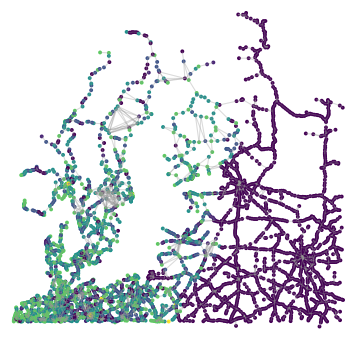

(<Figure size 926.744x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1215efdf0>)

In [3]:
from os import path
import osmnx as ox
import random

ox.config(log_console = True, data_folder = 'data')
src = 'nerails_with_pop.graphml'
graph = ox.load_graphml(src)
nodes = graph.nodes
random.seed(0)

for node in random.sample(nodes, 10):
    print(nodes[node]['population'])
    
def col(n):
    if n > 10000: return 1.0
    if n > 1000: return 0.75
    if n > 100: return 0.5
    if n > 10: return 0.25
    if n > 1: return 0.1
    else: return 0
colors = [col(int(graph.nodes[node]['population'])) for node in graph.nodes]
ox.plot_graph(
    graph, 
    node_color=colors, 
    edge_alpha=0.2
)